In [177]:
%matplotlib notebook

import sys
from typing import List, Tuple, Optional
from configparser import ConfigParser
import random
import time

sys.path.insert(0, "../../../global_route_planner/")

import numpy as np
import carla
from agents.navigation.local_planner import LocalPlanner, _compute_connection
from shapely.geometry import LineString, Point
from matplotlib import pyplot as plt
from IPython import display

from shapely.geometry import LineString, Point

from global_planner import get_client, spawn_vehicle, draw_waypoints, get_global_planner
from cartesian_to_frenet import get_frenet_from_cartesian, get_path_linestring, get_cartesian_from_frenet

sys.path.insert(0, "../../../carla_utils/utils/")


from utility import LanePoint
from actors import Actor, Vehicle

In [2]:
def filter_waypoints(waypoints, road_id, lane_id = None):
    
    filtered_waypoints = []
    for wp in waypoints:
        
        if lane_id == None and wp.road_id == road_id:
            filtered_waypoints.append(wp) 
        elif wp.road_id == road_id and wp.lane_id==lane_id:
            filtered_waypoints.append(wp) 

    return filtered_waypoints


def spawn_vehicle(
    world: carla.libcarla.World,
    vehicle_type: str = "model3",
    spawn_point: Optional[carla.libcarla.Transform] = None,
) -> carla.libcarla.Vehicle:
    """
    Spawns a vehicle at a given spawn point. Default car model is 'model3'.
    If no spawn point is provided, randomly selects the spawn point from the set of pre-assigned spawn points in the map.
    """

    if spawn_point is None:
        spawn_point = random.choice(world.get_map().get_spawn_points())
    vehicle_blueprint = world.get_blueprint_library().filter(vehicle_type)[0]
    vehicle = world.spawn_actor(vehicle_blueprint, spawn_point)
    return vehicle

In [3]:
# Get client to interact with CARLA server
client = get_client()

# Get current CARLA world
world = client.get_world()

Connection to CARLA server established!


In [76]:
for actors in world.get_actors().filter('vehicle*'):
    actors.destroy()

In [77]:
all_waypoints = world.get_map().generate_waypoints(1)

filtered_waypoints_1 = filter_waypoints(all_waypoints, 37, -2)
filtered_waypoints_2 = filter_waypoints(all_waypoints, 37, -1)


draw_waypoints(world, filtered_waypoints_2, 5)

In [81]:
wps_1 = np.random.choice(filtered_waypoints_1[300:-500], 1)
wps_2 = np.random.choice(filtered_waypoints_2[250:-100], 10)

draw_waypoints(world, wps_2, 5)

In [79]:
actors_1 = []
for wp in wps_1:
    
    x = wp.transform.location.x
    y = wp.transform.location.y
    z = wp.transform.location.z + 5
    yaw = wp.transform.rotation.yaw
    transform = carla.Transform(carla.Location(x=x,y=y,z=z), carla.Rotation(yaw=yaw))

    actors_1.append(spawn_vehicle(world, 'model3', transform))

    


In [80]:
actors_1 = [Vehicle(world, actor.id) for actor in actors_1]

In [82]:
actors_2 = []
for wp in wps_2:
    
    x = wp.transform.location.x
    y = wp.transform.location.y
    z = wp.transform.location.z + 5
    yaw = wp.transform.rotation.yaw
    transform = carla.Transform(carla.Location(x=x,y=y,z=z), carla.Rotation(yaw=yaw))

    actors_2.append(spawn_vehicle(world, 'model3', transform))

In [83]:
actors_2 = [Vehicle(world, actor.id) for actor in actors_2]

In [84]:
def get_path_linestring(waypoints) -> LineString:

    coordinates = [
        [waypoint.transform.location.x, waypoint.transform.location.y]
        for waypoint in waypoints
    ]
    # coordinates = [
    #     [lanepoint.global_pose.x, lanepoint.global_pose.y] for lanepoint in lanepoints
    # ]
    shapely_linestring = LineString(coordinates)
    return shapely_linestring


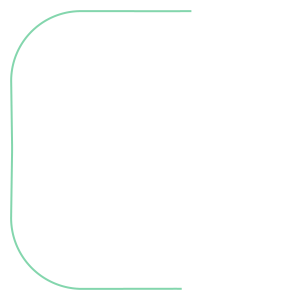

In [144]:
curr_linestring = get_path_linestring(filtered_waypoints_1)
curr_linestring

In [103]:
get_frenet_from_cartesian(curr_linestring, Point(actors_1[0].location_global.x, actors_1[0].location_global.y), actors_1[0].location_global.theta)
print(actors_1[0].location_global.x, actors_1[0].location_global.y)

-244.3483123779297 -99.47716522216797


In [136]:
i = 0
print(get_frenet_from_cartesian(curr_linestring, Point(actors_2[i].location_global.x, actors_2[i].location_global.y), actors_2[i].location_global.theta))
print(actors_2[i].location_global.x, actors_2[i].location_global.y)

(442.1503515911033, -3.50251380372922, -89.22514108089065, <shapely.geometry.point.Point object at 0x7f518430e438>)
-239.75595092773438 31.46881675720215


In [133]:
closest_actors = Vehicle.getClosest(actors_2, actors_1[0], 2)

In [134]:
for actor in closest_actors[0]:
    location = carla.Location(x=actor.location_global.x, y=actor.location_global.y)
    
    world.debug.draw_string(location, 'O', draw_shadow=False,
                                       color=carla.Color(r=255, g=0, b=0), life_time=5.0)
#     world.debug.draw_point(location, life_time=3)

In [123]:
location.z

0.0

In [ ]:
idx = -1
draw_waypoints(world, [wps[idx]], 10)


print(wps[idx].transform.location.x, wps[idx].transform.location.y)

ego_vehicle = actors[idx]
ego_lane_linestring = get_path_linestring(filtered_waypoints)
ego_vehicle_location_point = Point(ego_vehicle.location['x'], ego_vehicle.location['y'])
ego_vehicle_heading = ego_vehicle.location_global.theta
ego_vehicle_frenet_coordinates = get_frenet_from_cartesian(ego_lane_linestring, ego_vehicle_location_point, ego_vehicle_heading)
ego_vehicle_frenet_coordinates

In [ ]:
carla.DebugHelper.draw_point(carla.Location(x=))

In [148]:
lane = shapely.wkt.loads('LINESTRING (7.05682897567749 -207.4829711914062, 6.056838035583496 -207.4787292480469, 5.056847095489502 -207.4744873046875, 4.05685567855835 -207.4702453613281, 3.056864976882935 -207.4660186767578, 2.056873798370361 -207.4617767333984, 1.056882977485657 -207.4575347900391, 0.06738194823265076 -207.4536895751953, -0.915117084980011 -207.4516906738281, -1.897616147994995 -207.45166015625, -2.894335269927979 -207.4529418945312, -3.894334316253662 -207.4542541503906, -4.894333362579346 -207.4555969238281, -5.894332408905029 -207.4569396972656, -6.894331455230713 -207.4582824707031, -7.894330501556396 -207.4595947265625, -8.894330978393555 -207.4609375, -9.894329071044922 -207.4622802734375, -10.89432811737061 -207.4635925292969, -11.89432716369629 -207.4649353027344, -12.89432716369629 -207.4662780761719, -13.89432621002197 -207.4676208496094, -14.89432525634766 -207.4689331054688, -15.89432430267334 -207.4702758789062, -16.89432334899902 -207.4716186523438, -17.89432144165039 -207.4729309082031, -18.89432144165039 -207.4742736816406, -19.89432144165039 -207.4756164550781, -20.89431953430176 -207.4769592285156, -21.89431953430176 -207.478271484375, -22.89431762695312 -207.4796142578125, -23.89431762695312 -207.48095703125, -24.89431571960449 -207.4822692871094, -25.89431571960449 -207.4836120605469, -26.89431381225586 -207.4849548339844, -27.89431381225586 -207.4862976074219, -28.89431190490723 -207.4876098632812, -29.89431190490723 -207.4889526367188, -30.89430999755859 -207.4902954101562, -31.89430999755859 -207.4916076660156, -32.89430999755859 -207.4929504394531, -33.89430999755859 -207.4942932128906, -34.89430999755859 -207.4956359863281, -35.89430999755859 -207.4969482421875, -36.89430236816406 -207.498291015625, -37.89430236816406 -207.4996337890625, -38.89430236816406 -207.5009460449219, -39.89430236816406 -207.5022888183594, -40.89430236816406 -207.5036315917969, -41.89430236816406 -207.5049743652344, -42.89430236816406 -207.5062866210938, -43.89430236816406 -207.5076293945312, -44.89429473876953 -207.5089721679688, -45.89429473876953 -207.5102844238281, -46.89429473876953 -207.5116271972656, -47.89429473876953 -207.5129699707031, -48.89429473876953 -207.5143127441406, -49.89429473876953 -207.515625, -50.89429473876953 -207.5169677734375, -51.89429473876953 -207.518310546875, -52.89429473876953 -207.5196228027344, -53.894287109375 -207.5209655761719, -54.894287109375 -207.5223083496094, -55.894287109375 -207.5236511230469, -56.894287109375 -207.5249633789062, -57.894287109375 -207.5263061523438, -58.894287109375 -207.5276489257812, -59.894287109375 -207.5289611816406, -60.894287109375 -207.5303039550781, -61.89427947998047 -207.5316467285156, -62.89427947998047 -207.5329895019531, -63.89427947998047 -207.5343017578125, -64.89427947998047 -207.53564453125, -65.89427947998047 -207.5369873046875, -66.89427947998047 -207.5382995605469, -67.89427947998047 -207.5396423339844, -68.89427947998047 -207.5409851074219, -69.89427947998047 -207.5423278808594, -70.89427947998047 -207.5436401367188, -71.89427947998047 -207.5449829101562, -72.89427185058594 -207.5463256835938, -73.89427185058594 -207.5476379394531, -74.89427185058594 -207.5489807128906, -75.89427185058594 -207.5503234863281, -76.89427185058594 -207.5516662597656, -77.89427185058594 -207.552978515625, -78.89427185058594 -207.5543212890625, -79.89427185058594 -207.5556640625, -80.89427185058594 -207.5569763183594, -81.89426422119141 -207.5583190917969, -82.89426422119141 -207.5596618652344, -83.89426422119141 -207.5610046386719, -84.89426422119141 -207.5623168945312, -85.89426422119141 -207.5636596679688, -86.89426422119141 -207.5650024414062, -87.89426422119141 -207.5663146972656, -88.89426422119141 -207.5676574707031, -89.89425659179688 -207.5690002441406, -90.89425659179688 -207.5703430175781, -91.89425659179688 -207.5716552734375, -92.89425659179688 -207.572998046875, -93.89425659179688 -207.5743408203125, -94.89425659179688 -207.5756530761719, -95.89425659179688 -207.5769958496094, -96.89425659179688 -207.5783386230469, -97.89425659179688 -207.5796813964844, -98.89424896240234 -207.5809936523438, -99.89424896240234 -207.5823364257812, -100.8942489624023 -207.5836791992188, -101.8942489624023 -207.5849914550781, -102.8942489624023 -207.5863342285156, -103.8942489624023 -207.5876770019531, -104.8942489624023 -207.5890197753906, -105.8942489624023 -207.59033203125, -106.8942413330078 -207.5916748046875, -107.8942413330078 -207.593017578125, -108.8942413330078 -207.5943298339844, -109.8942413330078 -207.5956726074219, -110.8942413330078 -207.5970153808594, -111.8942413330078 -207.5983581542969, -112.8942413330078 -207.5996704101562, -113.8942413330078 -207.6010131835938, -114.8942413330078 -207.6023559570312, -115.8942337036133 -207.6036682128906, -116.8942337036133 -207.6050109863281, -117.8942337036133 -207.6063537597656, -118.8942337036133 -207.6076965332031, -119.8942337036133 -207.6090087890625, -120.8942260742188 -207.6103515625, -121.8942260742188 -207.6116638183594, -122.8942260742188 -207.6130065917969, -123.8942260742188 -207.6143493652344, -124.8942260742188 -207.6156616210938, -125.8942260742188 -207.6170043945312, -126.8942260742188 -207.6183471679688, -127.8942260742188 -207.6196899414062, -128.8942260742188 -207.6210021972656, -129.8942260742188 -207.6223449707031, -130.8942260742188 -207.6236877441406, -131.8942260742188 -207.625, -132.8942108154297 -207.6263427734375, -133.8942108154297 -207.627685546875, -134.8942108154297 -207.6290283203125, -135.8942108154297 -207.6303405761719, -136.8942108154297 -207.6316833496094, -137.8942108154297 -207.6330261230469, -138.8942108154297 -207.6343383789062, -139.9076080322266 -207.6355895996094, -140.9957885742188 -207.6298828125, -142.0838623046875 -207.6132202148438, -143.1716918945312 -207.5855865478516, -144.2592010498047 -207.5469818115234, -145.3462524414062 -207.4974365234375, -146.4327697753906 -207.4369354248047, -147.5186157226562 -207.3654632568359, -148.6036834716797 -207.2830810546875, -149.6878662109375 -207.1897583007812, -150.7710571289062 -207.0854797363281, -151.8531341552734 -206.9703216552734, -152.9339904785156 -206.8442535400391, -154.0135498046875 -206.7072906494141, -155.0916442871094 -206.5594635009766, -156.1681976318359 -206.4007720947266, -157.2431182861328 -206.2312469482422, -158.3162536621094 -206.0508880615234, -159.3875122070312 -205.8597106933594, -160.4568176269531 -205.6577453613281, -161.5240020751953 -205.4450531005859, -162.5890045166016 -205.2215728759766, -163.6517028808594 -204.9873809814453, -164.7119903564453 -204.7424774169922, -165.7697296142578 -204.4869232177734, -166.8248748779297 -204.2206878662109, -167.8772583007812 -203.9438629150391, -168.9268035888672 -203.6564331054688, -169.9734039306641 -203.3584442138672, -171.0169219970703 -203.0499114990234, -172.0572967529297 -202.7308807373047, -173.0944213867188 -202.4013824462891, -174.1281585693359 -202.0614318847656, -175.1584014892578 -201.7111053466797, -176.1850891113281 -201.3503875732422, -177.2080535888672 -200.9793395996094, -178.2272491455078 -200.5980224609375, -179.2425537109375 -200.2064361572266, -180.2538452148438 -199.8046417236328, -181.2610473632812 -199.3926849365234, -182.2640380859375 -198.9705657958984, -183.2627258300781 -198.5383758544922, -184.2570037841797 -198.0961456298828, -185.2467803955078 -197.6439208984375, -186.23193359375 -197.1817169189453, -187.21240234375 -196.7096252441406, -188.1880340576172 -196.2276763916016, -189.1587829589844 -195.7359161376953, -190.12451171875 -195.2343902587891, -191.0851287841797 -194.7231750488281, -192.0405578613281 -194.2022857666016, -192.9906921386719 -193.6717834472656, -193.9354248046875 -193.1317596435547, -194.8746643066406 -192.5822143554688, -195.8083190917969 -192.0232391357422, -196.7362976074219 -191.4548797607422, -197.6585083007812 -190.877197265625, -198.5748291015625 -190.2902526855469, -199.4851837158203 -189.694091796875, -200.3894958496094 -189.0888061523438, -201.2876586914062 -188.4744110107422, -202.1795806884766 -187.8510131835938, -203.065185546875 -187.2186431884766, -203.9443511962891 -186.577392578125, -204.8170166015625 -185.9273071289062, -205.6830902099609 -185.2684478759766, -206.54248046875 -184.6008911132812, -207.3950958251953 -183.9247283935547, -208.2408447265625 -183.2399749755859, -209.0796661376953 -182.5467681884766, -209.9114379882812 -181.8451232910156, -210.7360992431641 -181.1351165771484, -211.5535736083984 -180.4168548583984, -212.3637542724609 -179.6903839111328, -213.1665802001953 -178.9557800292969, -213.9619598388672 -178.213134765625, -214.7498016357422 -177.4624938964844, -215.5300598144531 -176.7039489746094, -216.3026123046875 -175.9375915527344, -217.0674133300781 -175.1634826660156, -217.8243560791016 -174.3816833496094, -218.5733947753906 -173.5923309326172, -219.3144378662109 -172.7954406738281, -220.0474090576172 -171.9911346435547, -220.7722320556641 -171.1794738769531, -221.4888610839844 -170.3605499267578, -222.1971740722656 -169.5344390869141, -222.8971252441406 -168.7012481689453, -223.5886383056641 -167.8610229492188, -224.2716674804688 -167.0138854980469, -224.9461059570312 -166.1598968505859, -225.6119079589844 -165.2991638183594, -226.2690124511719 -164.4317474365234, -226.9173278808594 -163.5577697753906, -227.5567932128906 -162.6772918701172, -228.1873626708984 -161.7904205322266, -228.8089447021484 -160.8972320556641, -229.4215240478516 -159.9978332519531, -230.0249786376953 -159.09228515625, -230.6192779541016 -158.1807250976562, -231.2043762207031 -157.2631988525391, -231.7801818847656 -156.33984375, -232.3466491699219 -155.4107208251953, -232.9037322998047 -154.4759216308594, -233.4513549804688 -153.5355834960938, -233.9894866943359 -152.5897521972656, -234.5180511474609 -151.6385345458984, -235.0370025634766 -150.6820678710938, -235.5462951660156 -149.7203979492188, -236.0458374023438 -148.7536468505859, -236.5356292724609 -147.7819061279297, -237.0155944824219 -146.8052978515625, -237.4857025146484 -145.8238830566406, -237.9459075927734 -144.8377838134766, -238.3961334228516 -143.8470916748047, -238.8363342285156 -142.8519287109375, -239.2665100097656 -141.8523712158203, -239.6865692138672 -140.8485260009766, -240.0964965820312 -139.8404846191406, -240.4962463378906 -138.828369140625, -240.8857574462891 -137.8122863769531, -241.2650146484375 -136.7923278808594, -241.6339874267578 -135.7686004638672, -241.9926147460938 -134.7411956787109, -242.3408660888672 -133.7102355957031, -242.6786956787109 -132.6757965087891, -243.006103515625 -131.6380310058594, -243.3230133056641 -130.5970001220703, -243.6294250488281 -129.5528411865234, -243.9253082275391 -128.5056457519531, -244.2106018066406 -127.4555206298828, -244.4852905273438 -126.4025726318359, -244.7493743896484 -125.3469009399414, -245.0027923583984 -124.2886352539062, -245.2455596923828 -123.2278594970703, -245.4775848388672 -122.1646957397461, -245.6988983154297 -121.0992431640625, -245.9094390869141 -120.0316162109375, -246.1092224121094 -118.9619216918945, -246.2982177734375 -117.8902587890625, -246.4764099121094 -116.8167572021484, -246.6437530517578 -115.7415161132812, -246.8002777099609 -114.6646347045898, -246.9459075927734 -113.5862350463867, -247.0806732177734 -112.5064086914062, -247.2045593261719 -111.42529296875, -247.3175201416016 -110.3429870605469, -247.4195861816406 -109.2595825195312, -247.5107116699219 -108.1752166748047, -247.5909118652344 -107.0899810791016, -247.66015625 -106.0039901733398, -247.7184753417969 -104.917366027832, -247.7658233642578 -103.830207824707, -247.8022155761719 -102.7426223754883, -247.82763671875 -101.6547241210938, -247.8421020507812 -100.5666275024414, -247.8455810546875 -99.47843933105469, -247.8380889892578 -98.39027404785156, -247.8234405517578 -97.36572265625, -247.8087005615234 -96.36583709716797, -247.7939758300781 -95.36594390869141, -247.7792510986328 -94.36605072021484, -247.7645111083984 -93.36615753173828, -247.7497863769531 -92.36627197265625, -247.7350616455078 -91.36637878417969, -247.7203216552734 -90.36648559570312, -247.7055969238281 -89.36659240722656, -247.6908721923828 -88.36670684814453, -247.6761322021484 -87.36681365966797, -247.6614074707031 -86.36692047119141, -247.6466827392578 -85.36702728271484, -247.6319427490234 -84.36713409423828, -247.6172180175781 -83.36724090576172, -247.6024932861328 -82.36735534667969, -247.5877532958984 -81.36746215820312, -247.5730285644531 -80.36756896972656, -247.5583038330078 -79.36768341064453, -247.5435638427734 -78.36779022216797, -247.5288391113281 -77.36789703369141, -247.5141143798828 -76.36800384521484, -247.4993743896484 -75.36811065673828, -247.4846496582031 -74.36821746826172, -247.4699249267578 -73.36833190917969, -247.4551849365234 -72.36843872070312, -247.4404602050781 -71.36854553222656, -247.4257354736328 -70.36865997314453, -247.4109954833984 -69.36876678466797, -247.3962707519531 -68.36887359619141, -247.3815460205078 -67.36898040771484, -247.3668060302734 -66.36908721923828, -247.3520812988281 -65.36919403076172, -247.3373565673828 -64.36930084228516, -247.3226165771484 -63.36941146850586, -247.3078918457031 -62.3695182800293, -247.2931671142578 -61.36962890625, -247.2784271240234 -60.36973571777344, -247.2637023925781 -59.36984634399414, -247.2489776611328 -58.36995315551758, -247.2342376708984 -57.37006378173828, -247.2195129394531 -56.37017059326172, -247.2047882080078 -55.37027740478516, -247.1900482177734 -54.37038803100586, -247.1753234863281 -53.3704948425293, -247.1605834960938 -52.37060546875, -247.1458587646484 -51.37071228027344, -247.1311340332031 -50.37082290649414, -247.1163940429688 -49.37092971801758, -247.1016693115234 -48.37103652954102, -247.0869445800781 -47.37114715576172, -247.0722045898438 -46.37125396728516, -247.0574798583984 -45.37136459350586, -247.0427551269531 -44.3714714050293, -247.0280151367188 -43.37158203125, -247.0132904052734 -42.37168884277344, -246.9985656738281 -41.37179946899414, -246.9838256835938 -40.37190628051758, -246.9691009521484 -39.37201309204102, -246.9543762207031 -38.37212371826172, -246.9396362304688 -37.37223052978516, -246.9249114990234 -36.37234115600586, -246.9101867675781 -35.3724479675293, -246.8954467773438 -34.37255859375, -246.8807220458984 -33.3726692199707, -246.8659973144531 -32.37277603149414, -246.8512573242188 -31.37288284301758, -246.8365325927734 -30.37298965454102, -246.8218078613281 -29.37309646606445, -246.8070678710938 -28.37321090698242, -246.7923431396484 -27.37331771850586, -246.7776184082031 -26.3734245300293, -246.7628784179688 -25.37353134155273, -246.7481536865234 -24.3736457824707, -246.7334289550781 -23.37375259399414, -246.7186889648438 -22.37385940551758, -246.7039642333984 -21.37396621704102, -246.6892395019531 -20.37407302856445, -246.6744995117188 -19.37418746948242, -246.6597747802734 -18.37429428100586, -246.6450500488281 -17.3744010925293, -246.6303100585938 -16.37450790405273, -246.6155853271484 -15.37461566925049, -246.6008605957031 -14.37473011016846, -246.5861206054688 -13.37483692169189, -246.5713958740234 -12.37494373321533, -246.5566711425781 -11.37505054473877, -246.5419311523438 -10.37516498565674, -246.5272064208984 -9.375271797180176, -246.5124816894531 -8.375378608703613, -246.4977416992188 -7.375485420227051, -246.4830169677734 -6.375592231750488, -246.4682922363281 -5.375706672668457, -246.4536437988281 -4.377944469451904, -246.4403839111328 -3.395533561706543, -246.4291076660156 -2.413098573684692, -246.4197845458984 -1.43064272403717, -246.4124450683594 -0.4481712281703949, -246.4070434570312 0.5343142151832581, -246.4036254882812 1.516808271408081, -246.4021606445312 2.499307155609131, -246.4026641845703 3.481807231903076, -246.4051208496094 4.464303016662598, -246.4095611572266 5.446793079376221, -246.4159545898438 6.429272174835205, -246.42431640625 7.411736965179443, -246.4346618652344 8.394181251525879, -246.4469604492188 9.376605033874512, -246.4608917236328 10.37104892730713, -246.4750213623047 11.37094974517822, -246.4891510009766 12.370849609375, -246.5032958984375 13.37074947357178, -246.5174255371094 14.37065029144287, -246.5315704345703 15.37054920196533, -246.5457000732422 16.37045097351074, -246.5598449707031 17.3703498840332, -246.573974609375 18.3702507019043, -246.5881195068359 19.37015151977539, -246.6022491455078 20.37005233764648, -246.6163940429688 21.36995124816895, -246.6305236816406 22.36985015869141, -246.6446685791016 23.3697509765625, -246.6587982177734 24.36965179443359, -246.6729278564453 25.36955261230469, -246.6870727539062 26.36944961547852, -246.7012023925781 27.36935043334961, -246.7153472900391 28.3692512512207, -246.7294769287109 29.3691520690918, -246.7436218261719 30.36905288696289, -246.7577514648438 31.36895370483398, -246.7718963623047 32.36885070800781, -246.7860260009766 33.36875152587891, -246.8001708984375 34.36865234375, -246.8143005371094 35.36855316162109, -246.8284454345703 36.36845397949219, -246.8425750732422 37.36835098266602, -246.8567047119141 38.36825180053711, -246.870849609375 39.3681526184082, -246.8849792480469 40.3680534362793, -246.8991241455078 41.36795425415039, -246.9132537841797 42.36785125732422, -246.9273986816406 43.36775207519531, -246.9415283203125 44.36765289306641, -246.9556732177734 45.3675537109375, -246.9698028564453 46.36745071411133, -246.9839477539062 47.36735153198242, -246.9980773925781 48.36725234985352, -247.0122222900391 49.36715316772461, -247.0263519287109 50.3670539855957, -247.0404815673828 51.36695098876953, -247.0546264648438 52.36685180664062, -247.0687561035156 53.36675262451172, -247.0829010009766 54.36665344238281, -247.0970306396484 55.36655426025391, -247.1111755371094 56.36645126342773, -247.1253051757812 57.36635208129883, -247.1394500732422 58.36625289916992, -247.1535797119141 59.36615371704102, -247.167724609375 60.36605453491211, -247.1818542480469 61.36595153808594, -247.1959991455078 62.36585235595703, -247.2101287841797 63.36575317382812, -247.2242584228516 64.36565399169922, -247.2384033203125 65.36555480957031, -247.2525329589844 66.36545562744141, -247.2666778564453 67.3653564453125, -247.2808074951172 68.36525726318359, -247.2949523925781 69.36515808105469, -247.30908203125 70.36505889892578, -247.3232269287109 71.36495208740234, -247.3373565673828 72.36485290527344, -247.3515014648438 73.36475372314453, -247.3656311035156 74.36465454101562, -247.3797607421875 75.36455535888672, -247.3939056396484 76.36445617675781, -247.4080352783203 77.36435699462891, -247.4221801757812 78.3642578125, -247.4363098144531 79.36415863037109, -247.4504547119141 80.36405944824219, -247.4645843505859 81.36396026611328, -247.4787292480469 82.36386108398438, -247.4928588867188 83.36376190185547, -247.5070037841797 84.36365509033203, -247.5211334228516 85.36355590820312, -247.5352783203125 86.36345672607422, -247.5494079589844 87.36335754394531, -247.5635375976562 88.36325836181641, -247.5776824951172 89.3631591796875, -247.5918121337891 90.36305999755859, -247.60595703125 91.36296081542969, -247.6200866699219 92.36286163330078, -247.6342315673828 93.36276245117188, -247.6483612060547 94.36265563964844, -247.6625061035156 95.36255645751953, -247.6766357421875 96.36245727539062, -247.6907806396484 97.36235809326172, -247.7049102783203 98.36225891113281, -247.7190551757812 99.36215972900391, -247.7331848144531 100.362060546875, -247.747314453125 101.3822631835938, -247.7545776367188 102.4722137451172, -247.7506408691406 103.5621795654297, -247.7355041503906 104.6520538330078, -247.7091674804688 105.7417068481445, -247.6716003417969 106.8310241699219, -247.6228637695312 107.9199142456055, -247.5628967285156 109.0082397460938, -247.4917907714844 110.0958862304688, -247.4094543457031 111.182746887207, -247.3159790039062 112.2686996459961, -247.2113342285156 113.3536376953125, -247.0955352783203 114.4374465942383, -246.9685974121094 115.5199966430664, -246.8305358886719 116.6011962890625, -246.6813507080078 117.680908203125, -246.5210876464844 118.7590408325195, -246.3497467041016 119.8354644775391, -246.1673278808594 120.9100646972656, -245.9739074707031 121.9827270507812, -245.7694396972656 123.0533599853516, -245.5539703369141 124.1218185424805, -245.3275299072266 125.1880187988281, -245.0901336669922 126.2518157958984, -244.8418121337891 127.3131332397461, -244.5825958251953 128.371826171875, -244.3125 129.4278106689453, -244.0315704345703 130.48095703125, -243.7398223876953 131.5311584472656, -243.4372863769531 132.5782928466797, -243.1239929199219 133.6222839355469, -242.7999877929688 134.6629943847656, -242.4653015136719 135.7003173828125, -242.1199645996094 136.734130859375, -241.7640075683594 137.7643432617188, -241.3974761962891 138.7908325195312, -241.0204162597656 139.8135070800781, -240.6328582763672 140.8322601318359, -240.2348480224609 141.8469543457031, -239.826416015625 142.8575134277344, -239.4076232910156 143.8638153076172, -238.9784851074219 144.8657684326172, -238.5390930175781 145.8632507324219, -238.0894622802734 146.8561553955078, -237.6296234130859 147.8443908691406, -237.1596832275391 148.8278503417969, -236.6796264648438 149.8064117431641, -236.1895446777344 150.7799835205078, -235.6894683837891 151.7484893798828, -235.1794738769531 152.7117767333984, -234.6595764160156 153.6697845458984, -234.1298675537109 154.6223754882812, -233.5904083251953 155.5694732666016, -233.0412139892578 156.510986328125, -232.4823608398438 157.4468078613281, -231.9139404296875 158.3768157958984, -231.3359680175781 159.3009490966797, -230.74853515625 160.2190704345703, -230.1516876220703 161.131103515625, -229.5455017089844 162.0369567871094, -228.9300231933594 162.9365234375, -228.3053283691406 163.8297119140625, -227.6714782714844 164.7164611816406, -227.0285491943359 165.5966033935547, -226.3766021728516 166.4701080322266, -225.7156982421875 167.3368682861328, -225.0459289550781 168.19677734375, -224.3673553466797 169.0497589111328, -223.6800384521484 169.8957214355469, -222.9840545654297 170.7345581054688, -222.2794799804688 171.5661926269531, -221.5664215087891 172.3905487060547, -220.8448791503906 173.20751953125, -220.114990234375 174.0170288085938, -219.3768310546875 174.8190002441406, -218.6304473876953 175.6133270263672, -217.8759460449219 176.3999481201172, -217.1134033203125 177.1787567138672, -216.3428649902344 177.9496917724609, -215.564453125 178.712646484375, -214.7782440185547 179.4675903320312, -213.9842987060547 180.2143859863281, -213.1827392578125 180.9529724121094, -212.3736114501953 181.6832885742188, -211.5570220947266 182.4052429199219, -210.7330474853516 183.1187591552734, -209.9017791748047 183.8237762451172, -209.0633087158203 184.5201873779297, -208.2177124023438 185.2079620361328, -207.3650970458984 185.8869934082031, -206.5055389404297 186.5572204589844, -205.6391448974609 187.2185821533203, -204.7659912109375 187.8709716796875, -203.8861694335938 188.5143890380859, -202.9997863769531 189.1486968994141, -202.1069030761719 189.7738800048828, -201.2076568603516 190.3898162841797, -200.3021240234375 190.9964904785156, -199.3904113769531 191.5938262939453, -198.4726104736328 192.1817626953125, -197.5487823486328 192.7602081298828, -196.6190643310547 193.3291320800781, -195.6835632324219 193.8884735107422, -194.7423400878906 194.4381561279297, -193.7955322265625 194.9781188964844, -192.8431854248047 195.5083312988281, -191.8854675292969 196.0287322998047, -190.9224548339844 196.5392456054688, -189.9542236328125 197.0398254394531, -188.9808959960938 197.5304260253906, -188.0025939941406 198.0110015869141, -187.0193786621094 198.4814910888672, -186.0314025878906 198.9418334960938, -185.0387420654297 199.3919830322266, -184.0414886474609 199.8319244384766, -183.0397796630859 200.2615966796875, -182.03369140625 200.680908203125, -181.0233459472656 201.0898895263672, -180.0088500976562 201.4884338378906, -178.9903106689453 201.8765411376953, -177.9678344726562 202.2541351318359, -176.9415283203125 202.6212005615234, -175.9115142822266 202.9777069091797, -174.8778839111328 203.3235931396484, -173.8407440185547 203.6588287353516, -172.8002014160156 203.9833831787109, -171.7563934326172 204.2972259521484, -170.7093963623047 204.6003112792969, -169.6593475341797 204.8926391601562, -168.6063690185547 205.1741333007812, -167.5505218505859 205.4447784423828, -166.4919738769531 205.7045593261719, -165.4307861328125 205.9534454345703, -164.3670959472656 206.1913909912109, -163.3010406494141 206.4183959960938, -162.2326812744141 206.6344299316406, -161.1621551513672 206.8394622802734, -160.089599609375 207.0334777832031, -159.0150909423828 207.2164611816406, -157.9387664794922 207.3883666992188, -156.8607177734375 207.5492248535156, -155.7810821533203 207.6989593505859, -154.6999664306641 207.8375854492188, -153.6174621582031 207.9651184082031, -152.5337219238281 208.0814819335938, -151.4488525390625 208.1867065429688, -150.3629302978516 208.28076171875, -149.276123046875 208.3636474609375, -148.1885070800781 208.4353637695312, -147.1002197265625 208.4958801269531, -146.0113677978516 208.5452117919922, -144.9220581054688 208.5833587646484, -143.8324127197266 208.6102600097656, -142.7425537109375 208.6259918212891, -141.6569976806641 208.6305084228516, -140.6569976806641 208.6300201416016, -139.6569976806641 208.6295166015625, -138.6569976806641 208.6290130615234, -137.6569976806641 208.6285095214844, -136.6569976806641 208.6280059814453, -135.6569976806641 208.6275024414062, -134.6569976806641 208.6270141601562, -133.6569976806641 208.6265106201172, -132.6569976806641 208.6260070800781, -131.6569976806641 208.6255035400391, -130.6569976806641 208.625, -129.6569976806641 208.6244964599609, -128.6569976806641 208.6239929199219, -127.6569900512695 208.6235046386719, -126.6569900512695 208.6230010986328, -125.6569900512695 208.6224975585938, -124.6569900512695 208.6219940185547, -123.6569900512695 208.6214904785156, -122.6569900512695 208.6209869384766, -121.6569900512695 208.6204986572266, -120.6569900512695 208.6199951171875, -119.6569900512695 208.6194915771484, -118.6569900512695 208.6189880371094, -117.6569900512695 208.6184844970703, -116.6569900512695 208.6179962158203, -115.6569900512695 208.6174926757812, -114.6569900512695 208.6169891357422, -113.6569900512695 208.6164855957031, -112.6569900512695 208.6159820556641, -111.6569900512695 208.615478515625, -110.6569900512695 208.6149749755859, -109.6569900512695 208.6144866943359, -108.6569900512695 208.6139831542969, -107.6569900512695 208.6134796142578, -106.6569900512695 208.6129760742188, -105.6569900512695 208.6124725341797, -104.6569900512695 208.6119689941406, -103.6569900512695 208.6114807128906, -102.6569900512695 208.6109771728516, -101.6569900512695 208.6104736328125, -100.6569900512695 208.6099700927734, -99.65699005126953 208.6094665527344, -98.65699005126953 208.6089630126953, -97.65699005126953 208.6084747314453, -96.65699005126953 208.6079711914062, -95.65699005126953 208.6074676513672, -94.65699005126953 208.6069641113281, -93.65699005126953 208.6064605712891, -92.65699005126953 208.60595703125, -91.65699005126953 208.6054534912109, -90.65699005126953 208.6049652099609, -89.65699005126953 208.6044616699219, -88.65699005126953 208.6039581298828, -87.65699005126953 208.6034545898438, -86.65699005126953 208.6029510498047, -85.65699005126953 208.6024475097656, -84.65699005126953 208.6019592285156, -83.65699005126953 208.6014556884766, -82.65699005126953 208.6009521484375, -81.65699005126953 208.6004486083984, -80.65699005126953 208.5999450683594, -79.65699005126953 208.5994415283203, -78.65699005126953 208.5989532470703, -77.65699005126953 208.5984497070312, -76.65699005126953 208.5979461669922, -75.65699005126953 208.5974426269531, -74.65699005126953 208.5969390869141, -73.65699005126953 208.596435546875, -72.65699005126953 208.5959320068359, -71.65699005126953 208.5954437255859, -70.65699005126953 208.5949401855469, -69.65699005126953 208.5944366455078, -68.65699005126953 208.5939331054688, -67.65699005126953 208.5934295654297, -66.65699768066406 208.5929260253906, -65.65699768066406 208.5924377441406, -64.65699768066406 208.5919342041016, -63.65700149536133 208.5914306640625, -62.65700149536133 208.5909271240234, -61.65700149536133 208.5904235839844, -60.65700149536133 208.5899200439453, -59.65700149536133 208.5894317626953, -58.65700149536133 208.5889282226562, -57.65700149536133 208.5884246826172, -56.65700149536133 208.5879211425781, -55.65700149536133 208.5874176025391, -54.65700149536133 208.5869140625, -53.65700149536133 208.5864105224609, -52.65700149536133 208.5859222412109, -51.65700149536133 208.5854187011719, -50.65700149536133 208.5849151611328, -49.65700149536133 208.5844116210938, -48.65700149536133 208.5839080810547, -47.65700149536133 208.5834045410156, -46.65700149536133 208.5829162597656, -45.65700149536133 208.5824127197266, -44.65700149536133 208.5819091796875, -43.65700149536133 208.5814056396484, -42.65700149536133 208.5809020996094, -41.65700149536133 208.5803985595703, -40.65700149536133 208.5799102783203, -39.65700149536133 208.5794067382812, -38.65700149536133 208.5789031982422, -37.65700149536133 208.5783996582031, -36.65700149536133 208.5778961181641, -35.65700149536133 208.577392578125, -34.65700149536133 208.5768890380859, -33.65700149536133 208.5764007568359, -32.65700149536133 208.5758972167969, -31.6569995880127 208.5753936767578, -30.6569995880127 208.5748901367188, -29.6569995880127 208.5743865966797, -28.6569995880127 208.5738830566406, -27.6569995880127 208.5733947753906, -26.6569995880127 208.5728912353516, -25.6569995880127 208.5723876953125, -24.6569995880127 208.5718841552734, -23.6569995880127 208.5713806152344, -22.6569995880127 208.5708770751953, -21.6569995880127 208.5703887939453, -20.65700721740723 208.5698852539062, -19.65700721740723 208.5693817138672, -18.65700721740723 208.5688781738281, -17.65700721740723 208.5683746337891, -16.65700721740723 208.56787109375, -15.65700721740723 208.5673675537109, -14.65700721740723 208.5668792724609, -13.65700721740723 208.5663757324219, -12.65700721740723 208.5658721923828, -11.65700721740723 208.5653686523438, -10.65700721740723 208.5648651123047, -9.657007217407227 208.5643615722656, -8.657007217407227 208.5638732910156, -7.657007217407227 208.5633697509766, -6.657007217407227 208.5628662109375, -5.657007217407227 208.5623626708984, -4.657007217407227 208.5618591308594, -3.657007455825806 208.5613555908203, -2.657007455825806 208.5608673095703, -1.668549776077271 208.5607604980469, -0.6860514879226685 208.5625610351562, 0.2964412271976471 208.5662994384766, 1.294634699821472 208.5713348388672, 2.294622182846069 208.5763702392578, 3.294609785079956 208.5813903808594, 4.294596672058105 208.5864105224609, 5.294584274291992 208.5914306640625, 6.294571876525879 208.5964508056641, 7.294559001922607 208.6014862060547, 8.294546127319336 208.6065063476562, 9.294533729553223 208.6115264892578, 10.29452037811279 208.6165466308594, 11.29450798034668 208.62158203125, 12.29449558258057 208.6266021728516, 13.29448318481445 208.6316223144531, 14.29446983337402 208.6366424560547, 15.29445743560791 208.6416625976562, 16.29444694519043 208.6466979980469, 17.29443359375 208.6517181396484, 18.2944221496582 208.65673828125, 19.29440879821777 208.6617584228516, 20.29439735412598 208.6667785644531, 21.29438400268555 208.6718139648438)')

In [141]:
import shapely
import shapely.wkt

In [186]:
x= -246.87298583984375
y= -32.84530258178711
theta= 1.5560661164895593

In [187]:
p = Point(x,y)

In [195]:
a

(383.36296392115634,
 2.9952333751228362e-05,
 -4.970318621022543e-06,
 <shapely.geometry.point.Point at 0x7f518430dc18>)

In [196]:
a = get_frenet_from_cartesian(lane, p, theta)
get_cartesian_from_frenet(lane, [a[0],a[1]], a[2])

input: 383.36296392115634 2.9952333751228362e-05 -4.970318621022543e-06


(-246.87298583984375, -32.84530258178713, 1.556066116489559)

In [193]:
def get_frenet_from_cartesian(
    linestring: LineString,
    cartesian_point: Point,
    cartesian_heading: float = None,
    resolution: float = 0.01,
) -> Tuple[float, float, float, Point]:

    """
    Converts a point (x,y,heading) in the cartesian frame to it's frenet frame representation.

    :param linestring:
        A shapely 'LineString' (Polyline) that represents the centre line of the lane being used as
        the reference for the frenet frame.
    :param cartesian_point:
        A shapely 'Point' of the point in cartesian frame that has to be represented in the frenet frame.
    :param cartesian_heading:
        The heading associated with the cartesian point, in radians.
    :param resolution:
        The resolution used to calculate the heading direction of local sections of the lane LineString.

    :returns:
        Tuple of (s, d, frenet_heading, projection of cartesian_point on linestring)
    """

    # Get s and d. d is not associated with a direction here.
    s = linestring.project(cartesian_point)
    d = linestring.distance(cartesian_point)

    # Find closest point (to the input point) on the lane LineString.
    closest_point_on_linestring = linestring.interpolate(s)

    # Find heading direction of the lane LineString by using a small section of the LineString,
    # around closest_point_on_linestring computed above.
    local_section_of_spline_start = linestring.interpolate(max(0, s - resolution))
    local_section_of_spline_end = linestring.interpolate(
        min(linestring.length, s + resolution)
    )
    local_section_heading_in_cartesian_coordinates = np.degrees(
        np.arctan2(
            local_section_of_spline_end.y - local_section_of_spline_start.y,
            local_section_of_spline_end.x - local_section_of_spline_start.x,
        )
    )

    # Find heading in frenet frame.
    heading_relative_to_local_section_heading = (
        (cartesian_heading * 180 / np.pi) - local_section_heading_in_cartesian_coordinates
    )

    # Assign a direction (+ or -) to the distance d.
    heading_of_line_joining_input_points_and_its_closest_point_on_linestring = (
        np.degrees(
            np.arctan2(
                cartesian_point.y - closest_point_on_linestring.y,
                cartesian_point.x - closest_point_on_linestring.x,
            )
        )
    )
    relative_heading = (
        heading_of_line_joining_input_points_and_its_closest_point_on_linestring
        - local_section_heading_in_cartesian_coordinates
    )
    if relative_heading < 0 or relative_heading > 180:
        d = -1 * d

    return s, d, heading_relative_to_local_section_heading * np.pi / 180, closest_point_on_linestring

In [184]:
def get_cartesian_from_frenet(
    linestring: LineString,
    frenet_point: List[float],
    frenet_heading: float,
    resolution: float = 0.01,
) -> Tuple[float, float, float]:

    """
    Converts a point (s,d,frenet_heading) in the frenet frame to it's cartesian_frame representation.

    :param linestring:
        A shapely 'LineString' (Polyline) that represents the centre line of the lane being used as
        the reference for the frenet frame.
    :param frenet_point:
        A list of the form [s,d].
    :param frenet_heading:
        The heading associated with the frenet point, in degrees, in the frenet frame.
    :param resolution:
        The resolution used to calculate the heading direction of local sections of the lane LineString.

    :returns:
        Tuple of (x, y, heading), in the cartesian frame.
    """

    print("input:", frenet_point[0], frenet_point[1], frenet_heading)
    
    s = frenet_point[0]
    d = frenet_point[1]

    # Find point on the lane LineString at a runlength of s.
    point_on_linestring = linestring.interpolate(s)

    # Find heading direction of the lane LineString by using a small section of the LineString,
    # around point_on_linestring computed above.
    local_section_of_spline_start = linestring.interpolate(max(0, s - resolution))
    local_section_of_spline_end = linestring.interpolate(
        min(linestring.length, s + resolution)
    )
    local_section_heading_in_cartesian_coordinates = np.degrees(
        np.arctan2(
            local_section_of_spline_end.y - local_section_of_spline_start.y,
            local_section_of_spline_end.x - local_section_of_spline_start.x,
        )
    )

    # Get the cartesian point at offset by d, along a direction perpendicular to the heading of the local section of the lane LineString.
    angle_to_extend = (
        (local_section_heading_in_cartesian_coordinates + 90) * np.pi / 180
    )
    cartesian_point = [
        point_on_linestring.x + d * np.cos(angle_to_extend),
        point_on_linestring.y + d * np.sin(angle_to_extend),
    ]

    # Get the heading in cartesian frame.
    cartesian_heading = (
        local_section_heading_in_cartesian_coordinates * np.pi / 180 + frenet_heading
    )

    return cartesian_point[0], cartesian_point[1], cartesian_heading
